```
This software is part of GPU Ocean. 

Copyright (C) 2018, 2019 SINTEF Digital
Copyright (C) 2018 Norwegian Meteorological Institute

This notebook implements a test to investigate computational performance for
different block sizes for the model error kernels, for performance tuning

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

# Model Error Performance: Block Size Experiment

This notebook runs a few timesteps the CDKLM scheme with model errors for a range of different CUDA block sizes in the model errors. The optimal block size for the CDKLM scheme should already be known from before.
The efficiency of each simulation run is reported in a text file, which is later read and processed to obtain the most efficient block sizes on the GPU on your given system.

### To look at the results shown in the paper
Execute the cells below to read the results obtained for the paper and reproduce the optimalization results.

### To find your own optimal block sizes
Comment out the second to last line in the second cell (which overwrites the `test_filename` variable) in order to produce your own benchmark results. Optimal block sizes are typically not the same across different GPUs, so your results might differ from those reported in the paper.


In [1]:
%matplotlib inline

import re
import numpy as np
import pandas as pd
import subprocess
import os
import os.path
import time

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d, Axes3D

In [2]:
# Generate unique filename
test_filename = "model_error_blocksize_benchmark_run_0.txt"
file_test = 0
while (os.path.isfile(test_filename)):

    test_filename = "model_error_blocksize_benchmark_run_" + str(file_test) + ".txt"
    file_test += 1
    
    
#Use the existing file, do not generate new data
#test_filename = "model_error_blocksize_benchmark_run_0.txt"
print("Storing data in " + test_filename)

Storing data in model_error_blocksize_benchmark_run_2.txt


In [3]:
# Specify python command:
#python = "python"
python = "/home/havahol/miniconda3/envs/gpuocean/bin/python"

In [4]:
def runBenchmark(filename):
    sim = "CDKLM"
    
    block_width = np.array([4, 8, 12, 16, 24, 32])
    block_height = np.array([4, 8, 12, 16, 24, 32])
    #block_width=list(range(2,33,1))
    #block_height=list(range(2,33,1))
    
    print("Running with the following:")
    print("Widths: " + str(block_width))
    print("Heights: " + str(block_height))

    block_width_model_error, block_height_model_error = np.meshgrid(block_width, block_height)
    
    with open(test_filename, 'w') as test_file:
        test_file.write("##########################################################################\n")
        test_file.write("Using simulator CDKLM with model errors.\n")
        test_file.write("##########################################################################\n")
        for j in range(block_width_model_error.shape[1]):
            for i in range(block_width_model_error.shape[0]):

                tic = time.time()

                test_file.write("=========================================\n")
                test_file.write(sim + " [{:02d} x {:02d}]\n".format(block_width_model_error[i,j], 
                                                                       block_height_model_error[i,j]))
                test_file.write("-----------------------------------------\n")
                cmd = [ python, "scripts/run_model.py", 
                       "--block_width_model_error", str(block_width_model_error[i,j]), 
                       "--block_height_model_error", str(block_height_model_error[i,j]),
                       "--steps_per_download", "500"]
                p = subprocess.Popen(cmd, shell=False, stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
                output = p.stdout.read()
                test_file.write(str(output) + "\n")
                test_file.write("=========================================\n")
                test_file.write("\n")

                toc = time.time()

                infostr = sim + " [{:02d} x {:02d}] completed in {:.02f} s\n".format(block_width_model_error[i,j],
                                                                                        block_height_model_error[i,j], (toc-tic))
                test_file.write(infostr)
                print(infostr)

        test_file.write("\n\n\n")
        test_file.flush()
        os.fsync(test_file)


if not (os.path.isfile(test_filename)):
    runBenchmark(test_filename)
else:
    print("Using existing run in " + test_filename)

Running with the following:
Widths: [ 4  8 12 16 24 32]
Heights: [ 4  8 12 16 24 32]
CDKLM [04 x 04] completed in 15.93 s

CDKLM [04 x 08] completed in 11.52 s

CDKLM [04 x 12] completed in 10.79 s

CDKLM [04 x 16] completed in 9.89 s

CDKLM [04 x 24] completed in 9.20 s

CDKLM [04 x 32] completed in 8.99 s

CDKLM [08 x 04] completed in 11.09 s

CDKLM [08 x 08] completed in 9.39 s

CDKLM [08 x 12] completed in 8.75 s

CDKLM [08 x 16] completed in 8.52 s

CDKLM [08 x 24] completed in 8.64 s

CDKLM [08 x 32] completed in 8.54 s

CDKLM [12 x 04] completed in 10.36 s

CDKLM [12 x 08] completed in 8.72 s

CDKLM [12 x 12] completed in 8.70 s

CDKLM [12 x 16] completed in 8.60 s

CDKLM [12 x 24] completed in 8.50 s

CDKLM [12 x 32] completed in 8.53 s

CDKLM [16 x 04] completed in 9.42 s

CDKLM [16 x 08] completed in 8.20 s

CDKLM [16 x 12] completed in 8.56 s

CDKLM [16 x 16] completed in 8.44 s

CDKLM [16 x 24] completed in 8.44 s

CDKLM [16 x 32] completed in 8.51 s

CDKLM [24 x 04] comple

In [5]:
def getData(filename):
    # State variables
    simulator = None
    block_width = None
    block_height = None

    data = np.empty((0, 4))

    with open(filename) as origin_file:
        for line in origin_file:
            line = str(line)

            # Find simulator
            match = re.match('Using simulator (.+)\.', line)
            if match:
                simulator = match.group(1)
                
            if simulator == None:
                continue

            # Find block size
            match = re.match(simulator.split(' ')[0] + ' \[(\\d+) x (\\d+)\]$', line)
            if match:
                block_width = match.group(1)
                block_height = match.group(2)

            # Find simulator megacells
            match = re.match('.*Maximum megacells: (\\d+(\.\\d+)?)', line)
            if match:
                megacells = match.group(1)
                data = np.append(data, [[simulator, block_width, block_height, megacells]], axis=0)
                
                block_width = None
                block_height = None

    return data

data = getData(test_filename)
print(data)

[['CDKLM with model errors' '04' '04' '141.49284406']
 ['CDKLM with model errors' '04' '08' '205.18364232']
 ['CDKLM with model errors' '04' '12' '221.06112930']
 ['CDKLM with model errors' '04' '16' '245.50527150']
 ['CDKLM with model errors' '04' '24' '268.13653310']
 ['CDKLM with model errors' '04' '32' '275.61366168']
 ['CDKLM with model errors' '08' '04' '214.16826692']
 ['CDKLM with model errors' '08' '08' '260.33161199']
 ['CDKLM with model errors' '08' '12' '284.03612903']
 ['CDKLM with model errors' '08' '16' '292.48752407']
 ['CDKLM with model errors' '08' '24' '288.50102048']
 ['CDKLM with model errors' '08' '32' '293.05528869']
 ['CDKLM with model errors' '12' '04' '232.70732996']
 ['CDKLM with model errors' '12' '08' '284.99690426']
 ['CDKLM with model errors' '12' '12' '286.62660563']
 ['CDKLM with model errors' '12' '16' '290.73201521']
 ['CDKLM with model errors' '12' '24' '294.34310262']
 ['CDKLM with model errors' '12' '32' '292.50188388']
 ['CDKLM with model errors' 

['04' '08' '12' '16' '24' '32']
CDKLM with model errors
         04       08       12       16       24       32
04  141.493  205.184  221.061  245.505  268.137  275.614
08  214.168  260.332  284.036  292.488  288.501  293.055
12  232.707  284.997  286.627  290.732  294.343  292.502
16  258.693  293.693  292.694  297.185  295.948  295.247
24  279.093   288.89  293.801  292.711  287.745  279.919
32  286.837  295.488  294.306   295.08  283.829  286.956
Maximum=297.18
Minimum=141.49
Mean=274.16
[ 7. 10.]


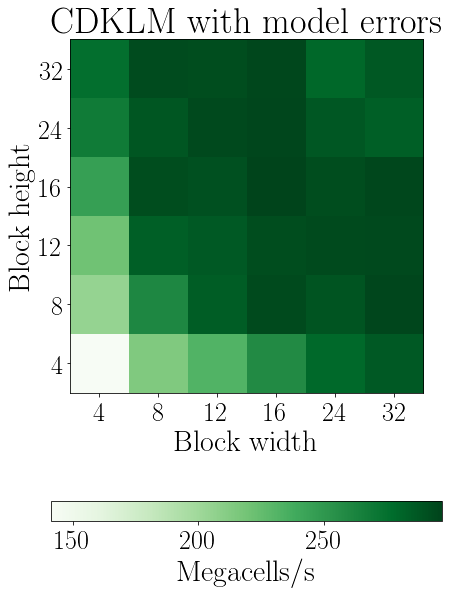

In [6]:
simulators = np.unique(data[:,0])
block_widths = np.unique(data[:,1])
block_heights = np.unique(data[:,2])

print(block_widths)

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

for simulator in simulators:
    print(simulator)
    
    df = pd.DataFrame(index=block_widths, columns=block_heights)

    # Pick this simulator data only and sort into a dataframe
    columns = data[:,0] == simulator
    for record in data[columns]:
        block_width = record[1]
        block_height = record[2]
        megacells = np.float32(record[3])
        df[block_height][block_width] = megacells
        
    maximum = np.nanmax(df.values)
    minimum = np.nanmin(df.values)
    mean = np.nanmean(df.values)
    print(df)
    print("Maximum={:.2f}".format(maximum))
    print("Minimum={:.2f}".format(minimum))
    print("Mean={:.2f}".format(mean))

    # Plot dataframe
    x = df.index.values.astype(np.int)
    y = df.columns.values.astype(np.int)
    z = np.transpose(df.values.astype(np.float32))
    
    fontsize=30
    fig = plt.figure(figsize=(7,10))
    ax = fig.add_subplot(111)
    img = ax.imshow(z, origin='lower', cmap=cm.Greens, interpolation="None")
    
    plt.xticks( range(len(x)), x, fontsize=fontsize-4)
    ax.set_xlabel('Block width', fontsize=fontsize)
    plt.yticks( range(len(y)), y, fontsize=fontsize-4)
    ax.set_ylabel('Block height', fontsize=fontsize)

    cb = plt.colorbar(img, orientation="horizontal", pad=0.2)
    cb.ax.tick_params(labelsize=fontsize-4)
    #cb.ax.set_ylabel('Megacells/s')#, rotation=270)
    cb.set_label('Megacells/s', fontsize=fontsize)#, labelpad=-40, y=0.45)



    
    #plt.title(simulator + " [megacells/s]", fontsize=fontsize+6)
    plt.title(simulator, fontsize=fontsize+6)
    fig.savefig(test_filename.replace('.txt', '_'+simulator+'.pdf'))
    print(fig.get_size_inches())

In [7]:
print(test_filename.replace('.txt', '_cdklm.pdf'))

model_error_blocksize_benchmark_run_2_cdklm.pdf
